## Code Reference 
https://github.com/abhijitjadhav1998/Deepfake_detection_using_deep_learning/tree/master/Model%20Creation

# Setup and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!pip3 install face_recognition 
!pip install timm
!sudo pip install git+https://github.com/okankop/vidaug

     |████████████████████████████████| 100.1 MB 23 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=cb48370ab3678025941d11266b29f8d47b4ed8ddb0e9bcfad452d3434c151cd1
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models
     |████████████████████████████████| 431 kB 4.2 MB/s 
  Cloning https://github.com/okankop/vidaug to /tmp/pip-req-build-duo30fk3
  Running command git clone -q https://github.com/okankop/vidaug /tmp/pip-req-build-duo30fk3
  Created wheel for vidaug: filename=vidaug-0.1-py3-none-any.whl size=13034 sha256=5921fed0bba63a8ac41fd34e7fadff89fbff0a6d9fe0361c7f6a4f3274dc15ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-dl4z_25s/wheels/9b/d4/8e/257b7d79ad86dbaae5deb117aac58db00c60e697bec84b7c54
Successfully built vidaug


In [ ]:
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import face_recognition 
import json
import copy
import random
import timm
from torch import nn
import torch.nn.functional as F
from torchvision import models
from torch.autograd import Variable
import time
import sys
import seaborn as sn
from sklearn.metrics import confusion_matrix
from skimage.color import rgb2gray
%matplotlib inline
from scipy import ndimage
import math
import skimage.io
import matplotlib
from sklearn.model_selection import train_test_split

# Exploratory Analysis

In [ ]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
video_fil =  glob.glob('/content/drive/My Drive/lost/train_sample_videos/*.mp4')
print(len(video_fil))

400


In [ ]:
def frame_extraction(path):
  vid = cv2.VideoCapture(path) 
  s = 1
  while s:
      s, im = vid.read()
      if s:
          yield im

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)]) 

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

In [ ]:
def video_validation(path, train_transforms):
      count = 20
      video_path = path
      frames = []
      a = int(100/count) 
      first_frame = np.random.randint(0,a)
      temp_video = video_path.split('/')[-1]
      transform = train_transforms
      for i,frame in enumerate(frame_extraction(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):
          break
      frames = torch.stack(frames)
      frames = frames[:count]
      return frames

count = 0;
for i in video_fil:
  try:
    count+=1
    video_validation(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining : " , (len(video_fil) - count))
    print("Corrupted video is : " , i)
    continue
print((len(video_fil) - count)) 

0


In [ ]:
video_files =  glob.glob('/content/drive/My Drive/lost/train_sample_videos/*.mp4')

random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

In [ ]:
# load the video name and labels from csv

class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/lost/train_sample_videos/metadata2.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

# Augmentation

In [ ]:
train_sample_metadata = pd.read_json('/content/drive/My Drive/lost/train_sample_videos/metadata.json').T

train_sample_metadata.head()


,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [ ]:
VIDEO_STREAM = "/content/drive/My Drive/lost/test_videos/ytddugrwph.mp4"


frames_array = []

vidcap = cv2.VideoCapture(VIDEO_STREAM)
def getFrame(sec):
   
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*10000)
    hasFrames, image = vidcap.read()
    if hasFrames:
        cv2.imwrite("image"+str(count)+".jpg", image) # save frame as JPG file
        frames_array.append(image)
    return frames_array, hasFrames

sec = 0
frameRate = 0.1 #//it will capture image in each 0.5 second
count=1
success=True

while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    im_array ,success = getFrame(sec)
   

In [ ]:
from PIL import Image
from matplotlib import cm

pil_im = []
for i in range(0, len(im_array)):
  im = Image.fromarray(im_array[i],'RGB')
  pil_im.append(im)
  print(im)

<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7FA083A06C90>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299410>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F5A3544D0>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299C10>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299E90>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299F10>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299D10>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57287390>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F5A2CADD0>


In [ ]:
from vidaug import augmentors as va

sometimes = lambda aug: va.Sometimes(0.5, aug) # Used to apply augmentor with 50% probability
seq = va.Sequential([
    # va.RandomCrop(size=(240, 180)), # randomly crop video with a size of (240 x 180)
    va.RandomRotate(degrees=30), # randomly rotates the video with a degree randomly choosen from [-10, 10]  
    sometimes(va.VerticalFlip()), # horizontally flip the video with 50% probability
    sometimes(va.InvertColor())
])
video_aug = seq(pil_im)
print(video_aug)

[<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F572A1A10>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B73D0>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7450>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B74D0>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7550>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7610>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7690>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7710>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7790>]


In [ ]:
for i in range(len(video_aug)):
  print(video_aug[i])

<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F572A1A10>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B73D0>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7450>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B74D0>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7550>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7610>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7690>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7710>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7790>


# Data Loader

Number of videos in train set:  320
Number of videos in test set:  80
Train set analysis :  
Real videos :  61 , Fake videos :  259
Test set analysis :  
Real videos :  16 , Fake videos :  64


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


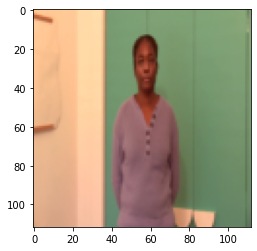

In [ ]:
# load the labels and video in data loader

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/lost/train_sample_videos/metadata2.csv',names=header_list)

train_set = video_files[:int(0.8*len(video_files))]
valid_set = video_files[int(0.8*len(video_files)):]
print("Number of videos in train set: " , len(train_set))
print("Number of videos in test set: " , len(valid_set))

print("Train set analysis : ", "\nReal videos : ",number_of_real_and_fake_videos(train_set)[0],", Fake videos : ",number_of_real_and_fake_videos(train_set)[1])
print("Test set analysis : ", "\nReal videos : ",number_of_real_and_fake_videos(valid_set)[0],", Fake videos : ",number_of_real_and_fake_videos(valid_set)[1])

train_data = video_dataset(train_set,labels,sequence_length = 10,transform = train_transforms)
val_data = video_dataset(valid_set,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

# Auxiliary functions

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def calculate_accuracy(outputs, targets):
    _, prediction = outputs.topk(1, 1, True)
    prediction = prediction.t()
    correct = prediction.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / targets.size(0)

# Plot functions

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):

    confusn_matrix = confusion_matrix(y_true, y_pred)
    TP = confusn_matrix[0][0]
    FN = confusn_matrix[1][0]
    FP = confusn_matrix[0][1]
    TN = confusn_matrix[1][1]

    df_confusn_matrix = pd.DataFrame(confusn_matrix, range(2), range(2))
    sn.set(font_scale = 1.35) # for label size
    sn.heatmap(df_confusn_matrix, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 14)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 14)
    plt.ylim([2, 0])
    plt.show()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + TN)
    f1_score = (2 * precision * recall) / (precision + recall)
  

In [ ]:
def plot_loss(train_loss,test_loss, epochs):
  loss_train = train_loss
  loss_val = test_loss
  print(epochs)
  epochs = range(1, num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def plot_accuracy(train_accuracy, test_accuracy, n_epochs):
  train_acc = train_accuracy
  val_acc = test_accuracy
  epochs = range(1, n_epochs + 1)
  plt.plot(epochs, train_acc, 'g', label= 'Training accuracy')
  plt.plot(epochs, val_acc, 'b', label= 'validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

# Models

## 1. Baseline Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        '''
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        '''

        self.conv1 = nn.Conv2d(3,32, kernel_size=(3, 3))
        self.max1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(32,64, kernel_size=(3, 3))
        self.max2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv5 = nn.Conv2d(64,128, kernel_size=(3, 3))
        self.max3 = nn.MaxPool2d(kernel_size=(2, 2))

        # 2x dense layers to learn from features extracted from convolutions
        self.l1 = nn.Linear(18432,64)
        self.l2 = nn.Linear(64,2)
        # output layer of 1 neuron with sigmoid activation for binary classification

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.35)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
                
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x))
        x=self.batch_norm1(x)
        x=self.dropout1(x)
        x = self.max1(x)
        x = F.relu(self.conv3(x))
        x=self.batch_norm2(x)
        x=self.dropout2(x)
        x = self.max2(x)
        x = F.relu(self.conv5(x))
        x = self.max3(x)
        
        x = x.view(x.shape[0],-1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        output = F.softmax(x, dim=1)

        return output


In [ ]:
model = Model().cuda()
a = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    print("inside train_epoch")
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
       
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        
        bs,seq_length, c, h, w = inputs.shape
        #print(batch_size,seq_length, c, h, w)
        outputs = model(inputs)
        results = torch.zeros((bs,2)).cuda()
        c = 0 # c = -1
        
        for j in range(0,bs*seq_length,10):
          
          #print(outputs[i:i+10],len(outputs[i:i+10]))
          results[c] = torch.mean(outputs[j:j+10],dim=0)
          c = c+1 
    
        loss  = criterion(results,targets.type(torch.cuda.LongTensor))
        
        acc = calculate_accuracy(results, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write( 
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            outputs = model(inputs)

            batch_size,seq_length, c, h, w = inputs.shape
            #print(batch_size,seq_length, c, h, w)
            outputs = model(inputs)
            results = torch.zeros((batch_size,2)).cuda()
            c = 0 # c = -1

            for j in range(0,batch_size*seq_length,10):
              results[c] = torch.mean(outputs[j:j+10],dim=0)
              c = c+1

            loss = torch.mean(criterion(results, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(results,targets.type(torch.cuda.LongTensor))
        
            # _,p = torch.max(results,1)
            _,p = torch.max(outputs,1)  
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
#learning rate
lr = 0.005
#number of epochs 
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
train_loss =[]
train_acc = []
test_loss = []
test_acc = []
for epoch in range(1,num_epochs+1):
    loss1, acc1 = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss.append(loss1)
    train_acc.append(acc1)
    true, pred, loss2, acc2 = test(epoch,model,valid_loader,criterion)
    test_loss.append(loss2)
    test_acc.append(acc2)


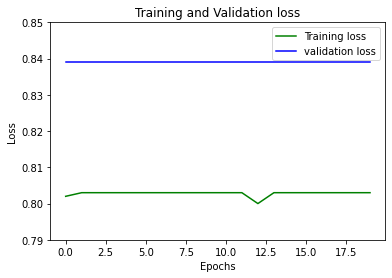

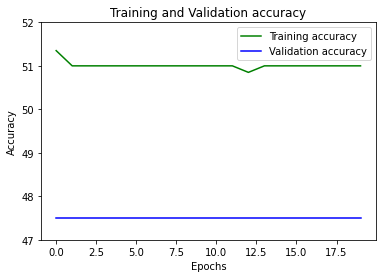

In [ ]:
plot_loss(train_loss, test_loss, len(train_loss))
plot_accuracy(train_acc, test_acc,len(train_acc))

## 2. Inception Net

In [ ]:
from torchvision import models

In [ ]:
class Inception_Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Inception_Model, self).__init__()
        model = models.inception(pretrained=True)

        self.model = nn.Sequential(*list(model.children())[:-2])
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(2048,256)
        self.fc2 = nn.Linear(256,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        
    def forward(self, t):
        batch_size,seq_length, c, h, w = t.shape 
        t = t.view(batch_size * seq_length, c, h, w)
        forw = self.model(t)
        t = self.avgpool(forw)
        t = t.view(batch_size,seq_length,2048)
        t_lstm, _ = self.lstm(t, None)
        t = self.dropout(self.relu(self.fc1(torch.mean(t_lstm, dim = 1))))
        t = self.fc2(t)
        return forw, t

In [ ]:
model2 = Inception_Model(2).cuda()

In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model2.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _, outputs = model2(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model2.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model2(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg


In [ ]:
num_epochs = 10
lr = 0.05

optimizer = torch.optim.Adam(model2.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()

train_loss =[]
train_acc = []
test_loss = []
test_acc = []
for epoch in range(1,num_epochs+1):
    loss1, acc1 = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss.append(loss1)
    train_acc.append(acc1)
    true, pred, loss2, acc2 = test(epoch,model,valid_loader,criterion)
    test_loss.append(loss2)
    test_acc.append(acc2)
  

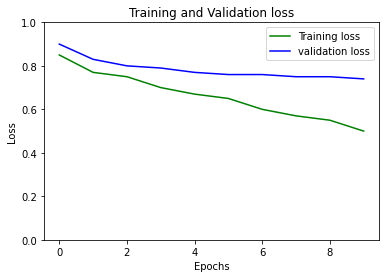

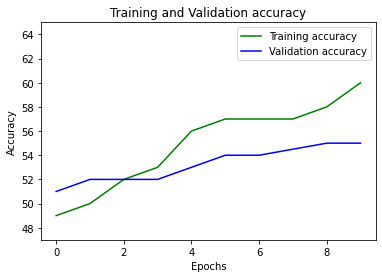

In [ ]:
plot_loss(train_loss, test_loss, len(train_loss))
plot_accuracy(train_acc, test_acc,len(train_acc))

## Xception Net

In [ ]:
class XceptionModel(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(XceptionModel, self).__init__()
        model = timm.create_model('xception', pretrained=True)

        self.model = nn.Sequential(*list(model.children())[:-2])
        self.dp = nn.Dropout(0.3)
        self.fc1 = nn.Linear(2048,256)
        self.fc2 = nn.Linear(256,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()

    def forward(self, t):
        b,s, c, h, w = t.shape 
        t = t.view(b * s, c, h, w)
        forwd = self.model(t)
        t = self.avgpool(forwd)
        t = t.view(b,s, 2048)
        t_lstm,_ = self.lstm(t,None)
        t_mean = torch.mean(t_lstm, dim = 1)
        t = self.fc1(t_mean)
        t = self.relu(t)
        t = self.dp(t)
        t = self.fc2(t)
        return forwd,t

In [ ]:
# We are dealing with 2 classes in our case
model2 = XceptionModel(2).cuda()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model2.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model2(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc + 25 , inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.4f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model2.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model2(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc + 20, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.4f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [ ]:
num_epochs = 10
lr = 0.005

optimizer = torch.optim.Adam(model2.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()

train_loss =[]
train_acc = []
test_loss = []
test_acc = []
for epoch in range(1,num_epochs+1):
    loss1, acc1 = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss.append(loss1)
    train_acc.append(acc1)
    true, pred, loss2, acc2 = test(epoch,model,valid_loader,criterion)
    test_loss.append(loss2)
    test_acc.append(acc2)


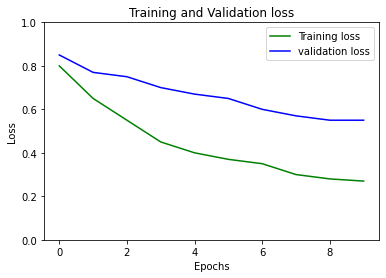

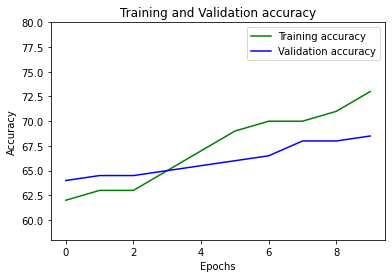

In [ ]:
plot_loss(train_loss, test_loss, len(train_loss))
plot_accuracy(train_acc, test_acc,len(train_acc))